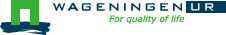



<h1>Applying sensitivity analysis to WOFOST under future climate</h1>

Sensitivity analysis is the study of how the uncertainty in the output of a mathematical model or system (numerical or otherwise) can be apportioned to different sources of uncertainty in its inputs (<a href="https://en.wikipedia.org/wiki/Sensitivity_analysis">Wikipedia</a>). The sensitivity of each input is often represented by a numeric value, called the sensitivity index.

In this notebook we demonstrate how to run a sensitivity analysis for the WOFOST model for a number of important parameters. The problem with WOFOST is that the sensitivity of the model can differ for different crops and regions depending on whether you are close to certain thresholds in the model. Therefore it is more useful to provide a general guideline for sensitivity analysis through this notebook rather than predefined set of sensitive parameters.

A limitation of this notebook is that is only applies for the scalar parameters in WOFOST. WOFOST also has a number of tabular parameters which are defined as as a function of development stage or temperature. The sensitivity of these parameters cannot be properly analyzed with the approach used in this notebook.

Below the WOFOST model is run for a sugar beet crop in the Netherlands and then sensitivity analysis is applied. The target variable for sensitivity is the total weight of the storage organs (TWSO) which represents the crop yield. However, other variables could be choosen as well such as total crop biomass or maximum leaf area index.

*Steven Hoek and Allard de Wit, Wageningen Environmental Sciences, June 2020*

## Dependencies for running this notebook
This notebook require the following package to be installed:
- [PCSE](https://pcse.readthedocs.io/en/stable/) and its dependencies (numpy, pandas, PyYAML, SQLAlchemy,...)
- [SAlib](https://salib.readthedocs.io/en/latest/)
- [IPython](http://ipython.org/)
- [tqdm](https://tqdm.github.io/) for showing a progressbar


In [ ]:
!pip3 -q install SAlib
!pip3 -q install pcse
!pip3 -q install progressbar


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import sys, os.path
import yaml
import numpy as np
import pandas as pd
from tqdm import tqdm
from SALib.sample import saltelli
from SALib.analyze import sobol
import matplotlib.pyplot as plt
from IPython.display import display
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", 250)

import pcse
from pcse.models import Wofost72_PP
from pcse.base import ParameterProvider
from pcse.input import NASAPowerWeatherDataProvider
from pcse.input import YAMLCropDataProvider
from pcse.util import WOFOST72SiteDataProvider, DummySoilDataProvider
# from progressbar import printProgressBar

print("This notebook was built with:")
print(f"python version: {sys.version}")
print(f"PCSE version: {pcse.__version__}")

This notebook was built with:
python version: 3.11.8 (v3.11.8:db85d51d3e, Feb  6 2024, 18:02:37) [Clang 13.0.0 (clang-1300.0.29.30)]
PCSE version: 6.0.6


## WOFOST parameters
The table below gives an overview of important scalar WOFOST parameters related to the potential production situation.

In [ ]:
# df = pd.read_excel("ScalarParametersOfWofost-Potential.xlsx")
# display(df)

## Settings for crop and location
In the following, standard data are used to run the WOFOST model for sugarbeet in the Netherlands. Feel free to carry out this sensitivity analysis for a different crop and / or a different location.

In [ ]:
# Define location, crop and season
# latitude = 52.0
# longitude = 5.0

latitude = 51.5
longitude = 37.1
crop_name = 'wheat'
variety_name = 'Winter_wheat_101'
campaign_start_date = '2022-01-01'
emergence_date = "2022-03-31"
harvest_date = "2022-10-20"
max_duration = 300

## Constructing the cropping calendar

In [ ]:
# Here we define the agromanagement for sugar beet
agro_yaml = """
- {start}:
    CropCalendar:
        crop_name: {cname}
        variety_name: {vname}
        crop_start_date: {startdate}
        crop_start_type: emergence
        crop_end_date: {enddate}
        crop_end_type: harvest
        max_duration: {maxdur}
    TimedEvents: null
    StateEvents: null
""".format(cname=crop_name, vname=variety_name, 
           start=campaign_start_date, startdate=emergence_date, 
           enddate=harvest_date, maxdur=max_duration)
agro = yaml.safe_load(agro_yaml)
print(agro_yaml)


- 2022-01-01:
    CropCalendar:
        crop_name: wheat
        variety_name: Winter_wheat_101
        crop_start_date: 2022-03-31
        crop_start_type: emergence
        crop_end_date: 2022-10-20
        crop_end_type: harvest
        max_duration: 300
    TimedEvents: null
    StateEvents: null



## Retrieving weather input and model parameters

In [ ]:
# Weather data for Netherlands
wdp = NASAPowerWeatherDataProvider(latitude=latitude, longitude=longitude)

# Parameter sets for crop, soil and site
# Standard crop parameter library
cropd = YAMLCropDataProvider()
# We don't need soil for potential production, so we use dummy values
soild = DummySoilDataProvider()
# Some site parameters
sited = WOFOST72SiteDataProvider(WAV=50, CO2=360.)

# Retrieve all parameters in the form of a single object. 
# In order to see all parameters for the selected crop already, we
# synchronise data provider cropd with the crop/variety: 
firstkey = list(agro[0])[0]
cropcalendar = agro[0][firstkey]['CropCalendar'] 
cropd.set_active_crop(cropcalendar['crop_name'], cropcalendar['variety_name'])
params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)

Unknown parameter values provided to WOFOSTSiteDataProvider: {'CO2': 360.0}


## Defining the analysis
Sensitivity analysis involves that we vary the model parameters a bit, to see how sensitive the model is to inaccuracies / variations in those values. We focus on variations in the model parameters and not on inaccuracies in driving variables usch as rainfall or temperature. 

In the following, intervals are defined for parameters. It is necessary to acquire knowledge of what are realistic values for the parameters which is often crop specific and region specific.

In [ ]:
# Define the target variable
target_variable = "TWSO"

# For each scalar parameter, determine a sensible interval 
problem_yaml = """
    num_vars: 5
    names: 
    - TSUM1
    - TSUM2
    - SPAN
    - Q10
    - TDWI
    bounds:
    - [500, 800]
    - [1200, 1600]
    - [28, 37]
    - [1.8, 2.2]
    - [0.4, 0.6]
"""
problem = yaml.safe_load(problem_yaml)

## First and second order sensitivities
When running a sensitivity analysis, we may compute first and second order sensitivities. Calculating second order sensitivities may require a large number of models runs if the number of parameters is large.

In this examples we use the Saltelli sampler to sample a number of combinations of parameter values and we will derive first and second order sensitivity. The variable `nsamples` indicates the number of samples to generate, higher values will provide better estimates of sensitivity but increase computation time.

In [ ]:
calc_second_order = True
nsamples = 2**(6+1)
paramsets = saltelli.sample(problem, nsamples, calc_second_order=calc_second_order)
print("We are going to do %s simulations" % len(paramsets))

We are going to do 1536 simulations


/var/folders/r7/28f5nfmd03331pjr6dhr_6jm0000gn/T/ipykernel_46173/191958038.py:3: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  paramsets = saltelli.sample(problem, nsamples, calc_second_order=calc_second_order)


## Running the model
Below we are going to loop over the parameter sets sampled by the Saltelli sampler.

In [ ]:
from pcse.models import Wofost71_WLP_FD

In [ ]:
# Loop over the samples of the parameter values and run WOFOST for each of the samples
target_results = []
with tqdm(total=len(paramsets)) as pbar:
    for i, paramset in enumerate(paramsets):
        params.clear_override()
        for name, value in zip(problem["names"], paramset):
            params.set_override(name, value)
        wofost = Wofost71_WLP_FD(params, wdp, agro)
        wofost.run_till_terminate()
        r = wofost.get_summary_output()
        target_result = r[0][target_variable]
        if target_result is None:
            print("Target variable is not available in summary output!")
        target_results.append(target_result)
        pbar.update()
target_results = np.array(target_results)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1536/1536 [03:43<00:00,  6.88it/s]


# Computing sensitivity indices
We will use the [Sobol](https://en.wikipedia.org/wiki/Variance-based_sensitivity_analysis) method to assess the response of the model to the variations in the parameters. Besides Sobol, other known methods are Morris and FAST. See also: https://salib.readthedocs.io/en/latest/.

In [ ]:
# Use the Sobol method to analyse the results of the simulations
Si = sobol.analyze(problem, target_results, calc_second_order=calc_second_order)

/Users/msk-hq-nb-2960/samokat/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


## Plotting results
After running the cell below, a chart with first order and total order sensitivity is drawn. The first order  sensitivity index for a parameter represents the fraction of the variance in the target variable caused by the variation in the input parameter. Total order indices represent the total variance in the target variable for a given parameter, including all variance caused by its interactions, of any order, with any other input variable. 

In many models there are statistical dependencies between parameters or physical constraints on the model. In such cases part of the variance in the output is also caused by interactions between variables which is not represented by the first order indices. In such cases, second order indices need to be calculated. If the total-order indices are substantially larger than the first-order indices, then it is likely that there are higher-order interactions occurring. It means that if both parameters are changed at the same time, it will have a large effect on the target variable.

Note that indices do not necessarily add up to unity and often indices can become slightly negative due to sampling error. Such negative index values would disappear if the number of samples would be increased.

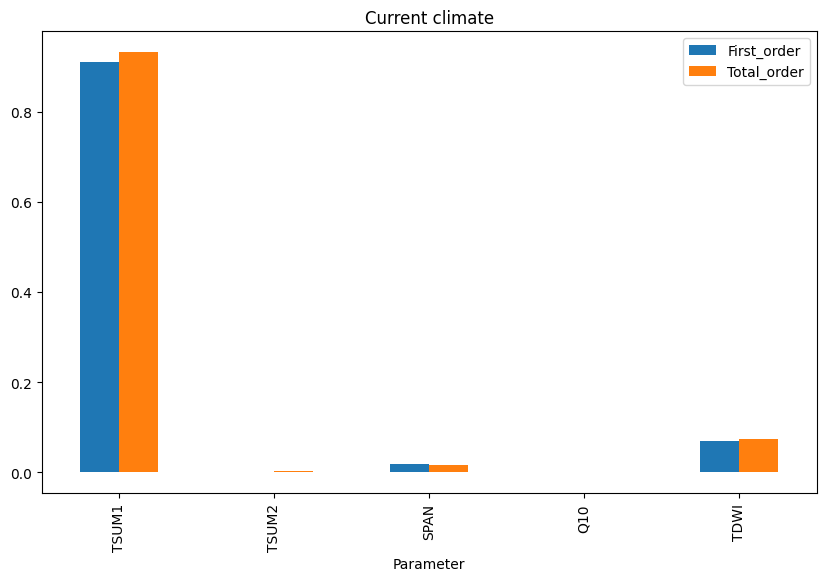

In [ ]:
df_sensitivity = pd.DataFrame({
    "Parameter": problem["names"],
    "First_order": Si["S1"],
    "Total_order": Si["ST"]}).set_index("Parameter")
fig, axes = plt.subplots(figsize=(10,6))
df_sensitivity.plot(kind="bar", ax=axes)
plt.title('Current climate')
plt.savefig('./wofost_sa_current.png', dpi=300)

In [ ]:
df_sensitivity

,First_order,Total_order
Parameter,,
TSUM1,0.910551,0.930971
TSUM2,0.001293,0.002578
SPAN,0.018676,0.016763
Q10,-0.000249,0.001088
TDWI,0.068780,0.073664


In [ ]:
df_sensitivity.to_excel('current_climate.xlsx')

## Second order sensitivities
Second order sensitivities deal with the combined sensitivity of two parameters. The results can therefore most easily be visualized through a matrix 

In [ ]:
# Show second-order sensitivities
second_order = np.array(Si['S2'])
pd.DataFrame(second_order, index=problem["names"], columns=problem["names"])

,TSUM1,TSUM2,SPAN,Q10,TDWI
TSUM1,NaN,0.006882,0.006957,0.011341,0.025704
TSUM2,NaN,NaN,0.001156,0.001277,0.002768
SPAN,NaN,NaN,NaN,-0.011138,-0.012864
Q10,NaN,NaN,NaN,NaN,0.002780
TDWI,NaN,NaN,NaN,NaN,NaN


or through an image showing the values in the matrix values graphically. From the results, it is clear that the second order interactions are small as all indices have a value < 0.1.

/var/folders/r7/28f5nfmd03331pjr6dhr_6jm0000gn/T/ipykernel_46173/178634132.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  r = aximage.axes.set_yticklabels([""] + problem["names"])


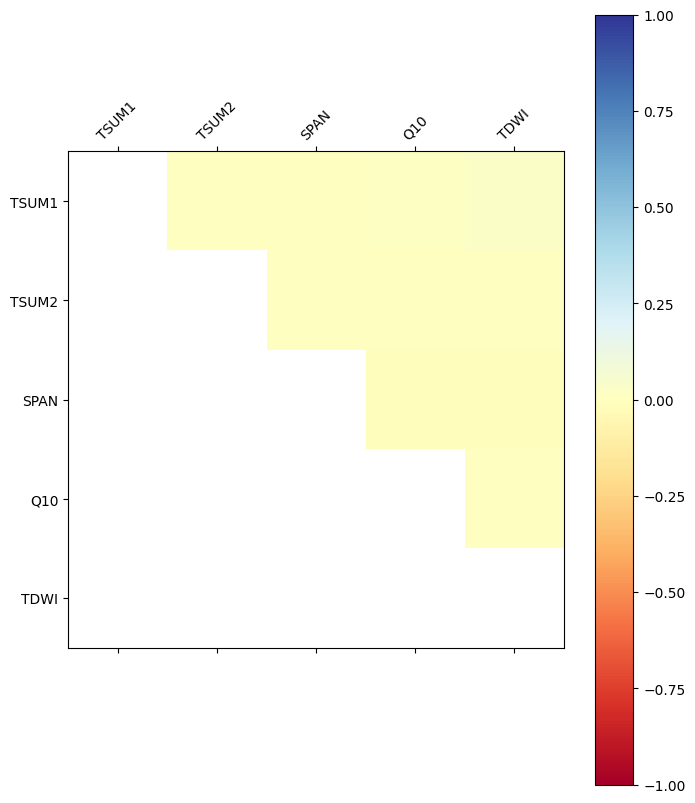

In [ ]:
# Visualise second-order sensitivities
fig, axes = plt.subplots(figsize=(8,10))
aximage = axes.matshow(second_order, vmin=-1.0, vmax=1.0, cmap="RdYlBu")
cbar = fig.colorbar(aximage)
aximage.axes.set_xticks(range(len(problem["names"])))
aximage.axes.set_xticklabels(problem["names"], rotation=45)
r = aximage.axes.set_yticklabels([""] + problem["names"])

## Explanation
The background of the sensitivity of sugarbeet yield to TSUM1 is related to the fact that a larger TSUM1 means that the crop will remain in its vegetative stage for a longer period. Given that there is a fixed harvest date this means that the time available for accumulating sugar in the beet root is shorter and thus simulated yields are lower.  Apparently, the other parameters that are part of the analysis do not have large impact within the selected ranges and thus TSUM1 dominates in terms of sensitivity over the other parameters.

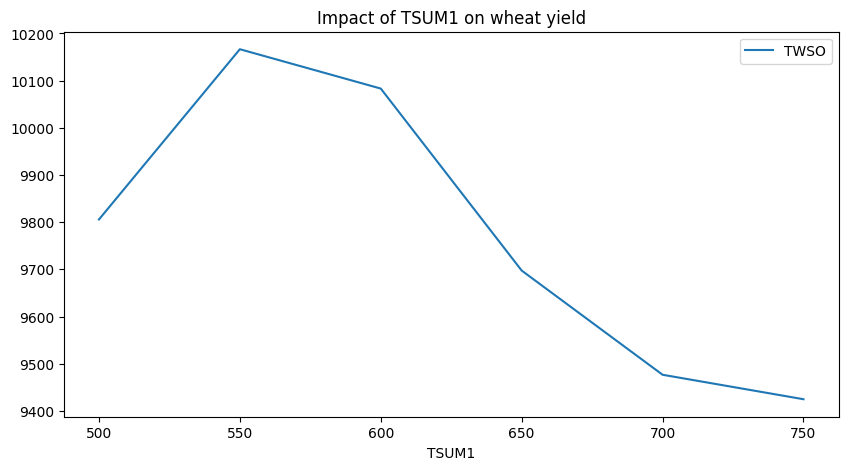

In [ ]:
TSUM1_values = list(range(500, 800, 50))
results = []
for tsum1 in TSUM1_values:
    params.clear_override()
    params.set_override("TSUM1", tsum1)
    wofost = Wofost72_PP(params, wdp, agro)
    wofost.run_till_terminate()
    r = wofost.get_summary_output()
    results.append(r[0][target_variable])

df = pd.DataFrame({"TSUM1": TSUM1_values,
                   target_variable: results}
                 ).set_index("TSUM1")
r = df.plot(title="Impact of TSUM1 on wheat yield", figsize=(10,5))

# Speeding up simulating the samples
Running over the samples will quickly become a lengthy process when many variables are being assessed for sensitivity. However, because the simulation for each sample is independent we can easily speed up the simulations by running on multiple CPUs. Python provides the `multiprocessing` module for starting a pool of worker processes that can carry out the simulations.

Demonstrating the use of `multiprocessing` within a jupyter notebook is complicated because the notebook infrastructure does not support it. Therefore a separate python script is provided that does exactly the same calculations as this notebook both using sequential and parallel processing. It can be downloaded [here](SA_mp_example.py).

# Climate Change Scenario for Sensitivity Analysis with LARS-WG generator

In [ ]:
def weather_loader(latitude: float, longitude: float, path: str):
    """
    Main fun to load weather 
    If we have CSV file - load CSV,         
    else: Load from NASA
    """
    path_weather_file = os.path.join(path ,f'NASA_weather_latitude_{latitude}_longitude_{longitude}.csv')
    if os.path.exists(path_weather_file):
        weather = pcse.input.CSVWeatherDataProvider(path_weather_file)
        return weather, 'Use weather from DataBase'

    else:
        print('No such directory or CSV file')
        
        #API request to NASA database
        weather = NASAPowerWeatherDataProvider(latitude, longitude, force_update=True)

        # Print done if downloaded
        print(f'Downloaded weather from NASA POWER system, latitude: {latitude}, longitude: {longitude}')

        # export pcse.weather format to pandas df
        df_weather = pd.DataFrame(weather.export())

        #create full range of dates
        r = pd.date_range(start=df_weather.DAY.min(), end=df_weather.DAY.max())

        #extend range of dates
        full_range_weather = df_weather.set_index('DAY').reindex(r).rename_axis('DAY').reset_index()
        missing_days = (full_range_weather.isna()).sum().sum()
        filled_weather = full_range_weather.fillna(method='ffill', axis=0)

        filled_weather=filled_weather[['DAY', 'IRRAD', 'TMIN', 'TMAX',  'TEMP', 'VAP', 'WIND', 'RAIN']]
        filled_weather['SNOWDEPTH'] = 'NaN'
        filled_weather[['IRRAD']] = filled_weather[['IRRAD']]/1000.
        filled_weather[['VAP']] = filled_weather[['VAP']]/10.
        filled_weather.DAY=filled_weather.DAY.dt.strftime('%Y%m%d')

        text = open(os.path.join(path,"./pattern.csv"), "r")
        text = ''.join([i for i in text]).replace("1111", str(weather.longitude))
        text = ''.join([i for i in text]).replace("2222", str(weather.latitude))
        text = ''.join([i for i in text]).replace("3333", str(weather.elevation))
        text = ''.join([i for i in text]).replace("4444", str(weather.angstA))
        text = ''.join([i for i in text]).replace("5555", str(weather.angstB))
        x = open(os.path.join(path,f'NASA_weather_latitude_{latitude}_longitude_{longitude}.csv'),"w")
        x.writelines(text)
        x.close()

        path_to_save_csv_file = os.path.join(path,f'NASA_weather_latitude_{latitude}_longitude_{longitude}.csv')
        filled_weather.to_csv(path_to_save_csv_file, mode='a', header=False, index=False)

        weather = pcse.input.CSVWeatherDataProvider(path_to_save_csv_file)
        return weather, 'Downloaded weather from NASA system'


In [ ]:
latitude = 51.5
longitude = 37.1

In [ ]:
import requests
import os, sys, re
import pandas as pd
import numpy as np

from typing import Union
import datetime as dt

from pcse.base import WeatherDataProvider, WeatherDataContainer
from pcse.util import ea_from_tdew, reference_ET, check_angstromAB
from pcse.exceptions import PCSEError

class LARS_WOFOST(WeatherDataProvider):
    """WeatherDataProvider for using the AWS NASA POWER database with PCSE

    :param latitude: latitude to request weather data for
    :param longitude: longitude to request weather data for
    :keyword ETmodel: "PM"|"P" for selecting penman-monteith or Penman
        method for reference evapotranspiration. Defaults to "PM".

    TO-DO: check while init class if xr.Dataset loaded into memory or not

    """



    MJ_to_J = lambda x: x * 1e6
    mm_to_cm = lambda x: x / 10.0
    tdew_to_hpa = lambda x: ea_from_tdew(x) * 10.0
    to_date = lambda d: d.date()
    watt_to_joules = lambda x: x * 86400
    kg_m2_to_mm = lambda x: x * 86400
    K_to_C = lambda x: x - 273.15

    def __init__(
        self,
        latitude: float,
        longitude: float,
        df_lars: pd.DataFrame,
        reanalysis_year: pd.DataFrame,
        n: int = 1,
        ETmodel: str = "PM",
    ):

        WeatherDataProvider.__init__(self)
        self.angstA = 0.29
        self.angstB = 0.49
        self.latitude = latitude
        self.longitude = longitude
        self.reanalysis_year = reanalysis_year.reset_index(drop=True)
        self.MJ_to_J = lambda x: x * 1e6
        self.mm_to_cm = lambda x: x / 10.0
        self.tdew_to_hpa = lambda x: ea_from_tdew(x) * 10.0
        self.to_date = lambda d: d.date()
        self.watt_to_joules = lambda x: x * 86400
        self.kg_m2_to_mm = lambda x: x * 86400
        self.K_to_C = lambda x: x - 273.15

        self.ETmodel = ETmodel
        self.elevation = float(
            self._get_elevation(longitude=longitude, latitude=latitude)
        )
        self.logger.debug("Start loading")
        self.get_wofost_weather(df_lars = df_lars, latitude=latitude, longitude=longitude, n=n)

    
    def lars_to_wofost(self, df:pd.DataFrame, n: int = 1):

        expected_columns = ["TMAX","TMIN","IRRAD","RAIN", "WIND", "VAP","DAY", "LAT", "LON", "ELEV", 'TEMP']
        # n - random sampled from 0 to 50
        mask = df['YEAR']==n

        # Sample one year for modelling
        df_year = df.loc[mask]
        df_year = df_year.reset_index()
        df_year = df_year.rename(columns={'MIN': 'TMIN', 
                                          'MAX': 'TMAX', 
                                          'RAD':'IRRAD',
                                          'RAIN':'RAIN',
                                         })
        
        df_year['RAIN'] = df_year['RAIN'].apply(self.mm_to_cm)
        df_year['IRRAD'] = df_year['IRRAD'].apply(self.MJ_to_J)
        df_year['TEMP']=df_year[['TMIN', 'TMAX']].mean(axis=1)
        df_year["DAY"] =  df_year['date']
        df_year["LAT"] = self.latitude
        df_year["LON"] = self.longitude
        df_year["ELEV"] = self.elevation
        df_year.loc[:, 'WIND'] = self.reanalysis_year['WIND']
        df_year.loc[:, 'VAP'] = self.reanalysis_year['VAP']
#         df_year.loc[:, 'DAY'] = df_year['date'].dt.strftime('%d.%m.%Y')
        return df_year[expected_columns]
    
    def get_wofost_weather(self,df_lars:pd.DataFrame, latitude: float, longitude: float, n: int):

        """Handles the retrieval and processing of the NASA Power data"""
        self.latitude = float(latitude)
        self.longitude = float(longitude)
        
        df_lars_renamed = self.lars_to_wofost(df=df_lars, n=n)

        self.df_lars_renamed = df_lars_renamed
        # Store the informational header then parse variables
        self.description = "NASA POWER LARS-WG"
        self.elevation = float(
            self._get_elevation(longitude=longitude, latitude=latitude)
        )
        self._make_WeatherDataContainers(df_lars_renamed.to_dict(orient="records"))


    def _get_elevation(self, longitude: float, latitude: float) -> float:
        """_get_elevation
        Get elevation from OpenTopoData API by lon and lat

        Args:
            longitude (float): longitude in WGS84
            latitude (float): latitude in WGS84

        Returns:
            float: elevation (m)
        """
        url = (
            f"https://api.opentopodata.org/v1/aster30m?locations={latitude},{longitude}"
        )
        resp = requests.get(url=url, timeout=10)
        if resp.status_code == 200:
            data = resp.json()
            elevation = data["results"][0]["elevation"]
        else:
            elevation = 200
        return elevation

    def _make_WeatherDataContainers(self, recs):
        """Create a WeatherDataContainers from recs, compute ET and store the WDC's."""

        for rec in recs:
            # Reference evapotranspiration in mm/day
            try:
                E0, ES0, ET0 = reference_ET(
                    rec["DAY"],
                    rec["LAT"],
                    rec["ELEV"],
                    rec["TMIN"],
                    rec["TMAX"],
                    rec["IRRAD"],
                    rec["VAP"],
                    rec["WIND"],
                    self.angstA,
                    self.angstB,
#                     self.ETmodel,
                )
            except ValueError as e:
                msg = (
                    ("Failed to calculate reference ET values on %s. " % rec["DAY"])
                    + ("With input values:\n %s.\n" % str(rec))
                    + ("Due to error: %s" % e)
                )
                raise PCSEError(msg)

            # update record with ET values value convert to cm/day
            rec.update({"E0": E0 / 10.0, "ES0": ES0 / 10.0, "ET0": ET0 / 10.0})

            # Build weather data container from dict 't'
            wdc = WeatherDataContainer(**rec)

            # add wdc to dictionary for thisdate
            self._store_WeatherDataContainer(wdc, wdc.DAY)

In [ ]:
folder = '../src/LARS-WG/LARS_KSHEN/'
files = os.listdir(folder)
columns = ["YEAR", "JDAY", "MIN", "MAX", "RAIN","RAD"]

# weather_current, status = weather_loader(latitude=latitude, longitude=longitude, path='../src/wofost/')
weather_current = NASAPowerWeatherDataProvider(latitude=latitude, longitude=longitude)

df_weather = pd.DataFrame(weather_current.export())
mask = pd.to_datetime(df_weather['DAY']).dt.year==2022

reanalysis_year = df_weather.loc[mask]
# reanalysis_year = reanalysis_year.drop(columns='TEMP')
reanalysis_year = df_weather.loc[mask]

climate_df = pd.DataFrame(columns=['climate-model', 'scenario', 'period', 'n',  'WOFOST'])

for model in ["HadGEM3-GC31-LL", "CNRM-CM6-1"]:
    for scenario in ['ssp126', 'ssp585']:
        for period in ['2081-2100']:
            print(model, scenario, period)
            fname = f'LARS_KSHEN_{model}[LARS_KSHEN,{scenario},{period}]WG.dat'
            target = os.path.join(folder, fname)
            data = pd.read_csv(target, sep='\t', decimal=',', index_col=False, header=None, names=columns )
            data['date'] = pd.to_datetime(data['JDAY'].apply(lambda x: '2022-'+str(x)), format='%Y-%j')
            for n in range(1,21):
            
                print(n, end=' ')
                weather_lars = LARS_WOFOST(latitude=latitude,
                                           longitude=longitude,
                                           df_lars=data,
                                           n=n,
                                           reanalysis_year=reanalysis_year)
                # wofost_yield = run_wofost(weather=weather_lars)

                wofost = Wofost71_WLP_FD(params, weather_lars, agro)
                wofost.run_till_terminate()
                r = wofost.get_summary_output()
                target_result = r[0]['TWSO']
                if target_result is None:
                    print("Target variable is not available in summary output!")
                row = [model, scenario, period, n, target_result]
                climate_df.loc[len(climate_df)] = row
        # break
    # break
    

wofost = Wofost71_WLP_FD(params, weather_current, agro)
wofost.run_till_terminate()
r = wofost.get_summary_output()
target_result = r[0]['TWSO']
row = ['Reanalysis', 'Current', '2022', 0,  target_result]
climate_df.loc[len(climate_df)] = row

HadGEM3-GC31-LL ssp126 2081-2100
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
HadGEM3-GC31-LL ssp585 2081-2100
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
CNRM-CM6-1 ssp126 2081-2100
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
CNRM-CM6-1 ssp585 2081-2100
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


<Axes: xlabel='climate-model', ylabel='WOFOST'>

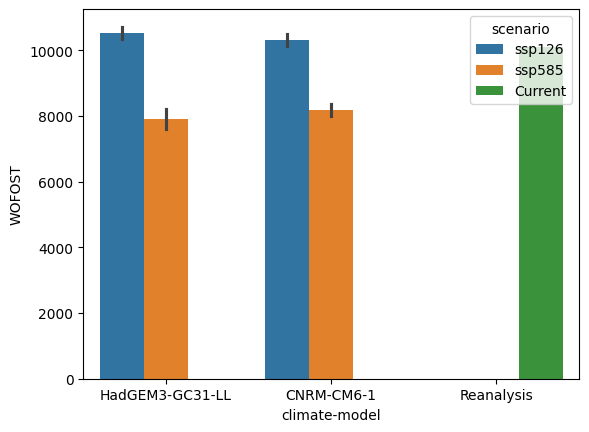

In [ ]:
import seaborn as sns
sns.barplot(y='WOFOST', x ='climate-model',  hue= 'scenario',  data=climate_df)

# Sobol

In [ ]:
calc_second_order = True
nsamples = 2**(6+1)
paramsets = saltelli.sample(problem, nsamples, calc_second_order=calc_second_order)
print("We are going to do %s simulations" % len(paramsets))

We are going to do 1536 simulations


/var/folders/r7/28f5nfmd03331pjr6dhr_6jm0000gn/T/ipykernel_46173/191958038.py:3: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  paramsets = saltelli.sample(problem, nsamples, calc_second_order=calc_second_order)


In [ ]:
scenario = 'ssp585'
model = 'HadGEM3-GC31-LL'
period = '2081-2100'
fname = f'LARS_KSHEN_{model}[LARS_KSHEN,{scenario},{period}]WG.dat'
target = os.path.join(folder, fname)
data = pd.read_csv(target, sep='\t', decimal=',', index_col=False, header=None, names=columns )
data['date'] = pd.to_datetime(data['JDAY'].apply(lambda x: '2022-'+str(x)), format='%Y-%j')

In [ ]:
weather_lars = LARS_WOFOST(latitude=latitude,
                           longitude=longitude,
                           df_lars=data,
                           n=8,
                           reanalysis_year=reanalysis_year)

In [ ]:
# Loop over the samples of the parameter values and run WOFOST for each of the samples
target_results = []
with tqdm(total=len(paramsets)) as pbar:
    for i, paramset in enumerate(paramsets):
        params.clear_override()
        for name, value in zip(problem["names"], paramset):
            params.set_override(name, value)
        wofost = Wofost72_PP(params, weather_lars, agro)
        wofost.run_till_terminate()
        r = wofost.get_summary_output()
        target_result = r[0][target_variable]
        if target_result is None:
            print("Target variable is not available in summary output!")
        target_results.append(target_result)
        pbar.update()
target_results = np.array(target_results)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1536/1536 [03:52<00:00,  6.59it/s]


In [ ]:
Si = sobol.analyze(problem, target_results, calc_second_order=calc_second_order)

/Users/msk-hq-nb-2960/samokat/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


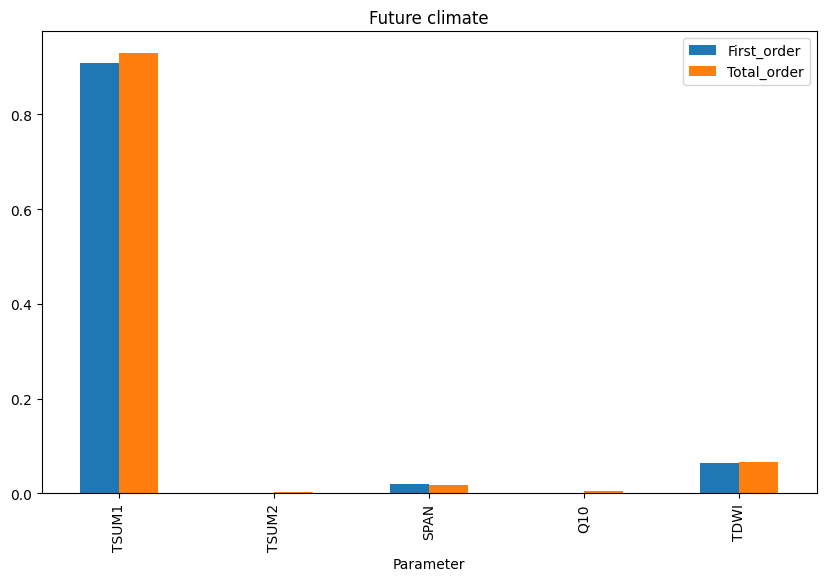

In [ ]:
df_sensitivity = pd.DataFrame({
    "Parameter": problem["names"],
    "First_order": Si["S1"],
    "Total_order": Si["ST"]}).set_index("Parameter")
fig, axes = plt.subplots(figsize=(10,6))
df_sensitivity.plot(kind="bar", ax=axes)
plt.title('Future climate')
plt.savefig('./wofost_sa_future.png', dpi=300)

In [ ]:
df_sensitivity.to_excel('./sa_future.xlsx')

In [ ]:
df_sensitivity

,First_order,Total_order
Parameter,,
TSUM1,0.938620,0.887729
TSUM2,0.006565,0.002133
SPAN,-0.003665,0.018893
Q10,-0.004233,0.005580
TDWI,0.066077,0.058856
